<div align="center">

  <a href="https://ultralytics.com/yolov5" target="_blank">
    <img width="500", src="https://raw.githubusercontent.com/ultralytics/assets/main/yolov5/v70/splash.png"></a>


<br>
  <a href="https://colab.research.google.com/drive/1AtzcPyWasr6uV43akDAh51cLam1Q3o0y?usp=sharing"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
  <!-- <a href="https://www.kaggle.com/ultralytics/yolov5"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle"></a> -->
<br>

Для датасета: https://www.kaggle.com/datasets/sshikamaru/car-object-detection

Обучить и протестировать модель, используя yolov5, и экспортнуть в tflite, onnx.

Можно также посмотреть в Colab (с большим числом эпох обучения): https://colab.research.google.com/drive/1AtzcPyWasr6uV43akDAh51cLam1Q3o0y?usp=sharing

Применена сегментация из модели.
</div>



In [1]:
import os
import shutil as sh
import zipfile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import clear_output
from PIL import Image
from tqdm import tqdm

import wandb

wandb.login()

clear_output()

## Загрузим YOLOV5

In [117]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...


In [118]:
!cd yolov5
!pip install -r ./yolov5/requirements.txt
clear_output()

## Загрузим датасет с wendb

In [ ]:
DIR_ZIP = './artifacts/cars-dataset-v1/'

run = wandb.init(project="shift_yolo")
artifact = run.use_artifact('balakinakate2022/shift_yolo/cars-dataset:v1', type='dataset')
artifact.download()

with zipfile.ZipFile(DIR_ZIP+"detect_cars.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [120]:
path = './data'
train_dir = path + '/training_images/'
test_dir = path + '/testing_images/'

print('Image(Train):',len(os.listdir(train_dir)))
print('Image(Test):',len(os.listdir(test_dir)))

Image(Train): 1001
Image(Test): 175


In [121]:
data = pd.read_csv(path + '/train_solution_bounding_boxes (1).csv')

In [122]:
data.head()

image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422

In [123]:
data.shape

(559, 5)

Посмотрим данные

Image shape: (380, 676, 3)
Name,xmin,ymin,xmax,ymax: 
 ['vid_4_28840.jpg', 238.7033285, 191.4366152, 322.8364689, 225.1817889]
Image shape: (380, 676, 3)
Name,xmin,ymin,xmax,ymax: 
 ['vid_4_920.jpg', 539.1260015, 163.8657707, 676.0, 229.332092]
Image shape: (380, 676, 3)
Name,xmin,ymin,xmax,ymax: 
 ['vid_4_22580.jpg', 21.52243126, 199.261583, 117.3950796, 239.8536036]


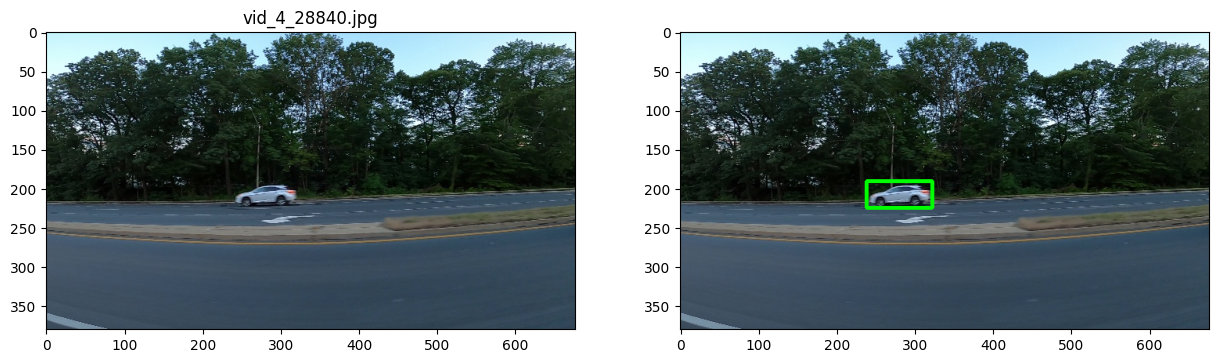

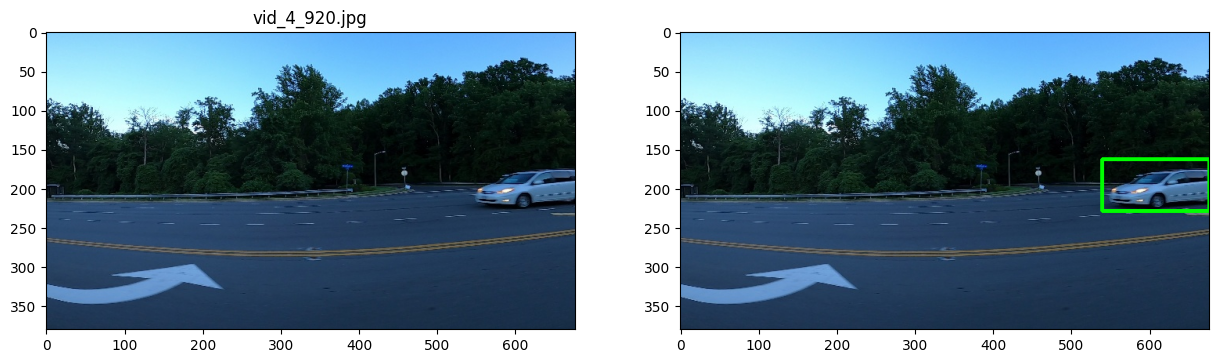

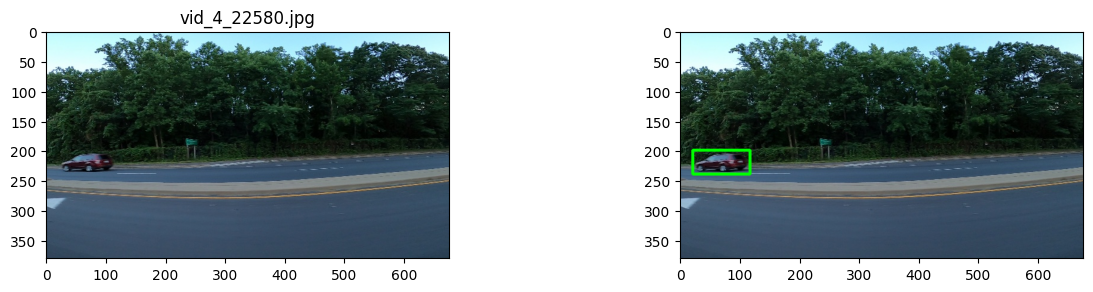

In [124]:
IMAGE_SHAPE = 0
for i in range(3): #data.values
    random = np.random.randint(0, data.shape[0])
    random_row = data.iloc[random]
    image = plt.imread(train_dir + random_row[0])
    plt.figure(figsize=[15,10])
    row = i + 1
    plt.subplot(row,2,1)
    plt.imshow(image)
    IMAGE_SHAPE = image.shape
    print('Image shape:',image.shape)
    plt.title(random_row[0])
    print('Name,xmin,ymin,xmax,ymax: \n',random_row.to_list())
    point1=(int(random_row[1]),int(random_row[2]))
    point2=(int(random_row[3]),int(random_row[4]))
    cv2.rectangle(image,point1,point2, color = (0, 255, 0), thickness = 3)
    plt.subplot(row,2,2)
    plt.imshow(image)

## Подготовим данные

Добавим колонки "x_center", "y_center", "w", "h"

In [125]:
img_h, img_w, num_channels = (IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2])
data['x_center'] = (data['xmin'] + data['xmax'])/2
data['y_center'] = (data['ymin'] + data['ymax'])/2
data['w'] = data['xmax'] - data['xmin']
data['h'] = data['ymax'] - data['ymin']
data['classes'] = 0
data['x_center'] = data['x_center']/img_w
data['w'] = data['w']/img_w
data['y_center'] = data['y_center']/img_h
data['h'] = data['h']/img_h
data.head()

image        xmin        ymin        xmax        ymax  x_center  \
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547  0.450434   
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180  0.100217   
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180  0.444645   
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575  0.833213   
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422  0.110347   

   y_center         w         h  classes  
0  0.539817  0.068741  0.095238        0  
1  0.557191  0.155572  0.129987        0  
2  0.543678  0.181621  0.157014        0  
3  0.531451  0.197540  0.155727        0  
4  0.559122  0.171491  0.136422        0

In [126]:
index = list(set(data.image))
len(index), len(data.image)

(355, 559)

Разобём по папкам тестовые и валидационные данные.

In [127]:
if not os.path.exists("data"):
    os.makedirs('data')
    os.makedirs('data/fold{}'.format(0))

In [128]:
source = 'training_images'

for fold in [0]:
    val_index = index[::5]  # 20% to val
    
    for name,mini in tqdm(data.groupby('image')):
        if name in val_index:
            path2save = 'val/'
        else:
            path2save = 'train/'

        if not os.path.exists('data/fold{}/labels/'.format(fold)+path2save):
            os.makedirs('data/fold{}/labels/'.format(fold)+path2save)
        with open('data/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
            row = mini[['classes','x_center','y_center','w','h']].astype(float).values
            row = row.astype(str)
            for j in range(len(row)):
                text = ' '.join(row[j])
                f.write(text)
                f.write("\n")
        if not os.path.exists('data/fold{}/images/{}'.format(fold,path2save)):
            os.makedirs('data/fold{}/images/{}'.format(fold,path2save))
        sh.copy(path + "/{}/{}".format(source,name),'./data/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

100%|██████████| 355/355 [00:00<00:00, 439.90it/s]


## Начнём обучение

In [129]:
%%writefile dataset.yaml
path: ../data/fold0
train: images/train
val: images/val
test:

names:
  0: car

Writing dataset.yaml


In [130]:
IMG_SIZE = IMAGE_SHAPE[1]
CONF_TRESHOLD = 0.6
IOU_THRESHOLD = 0.5
MODEL = 'yolov5s.pt' # 'yolov5x.pt'

# for write paths
num_starts = 0
num_detects = 0

In [131]:
import time

num_starts +=1
# start timer
start_time = time.perf_counter()

# training for yolov5s model
!python yolov5/train.py --img {IMG_SIZE} --batch 4 --epochs 10 --data dataset.yaml --weights {MODEL} --project shift_yolo --optimizer "AdamW"


# stop timer
end_time = time.perf_counter()

# calculate elapsed time
elapsed_time = end_time - start_time

print(f'Training time for {MODEL} model: {elapsed_time:0.2f} seconds')

Training time for yolov5s.pt model: 2190.32 seconds


wandb: WARNING  wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: balakinakate2022. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=dataset.yaml, hyp=yolov5\data\hyps\hyp.scratch-low.yaml, epochs=10, batch_size=4, imgsz=676, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=AdamW, sync_bn=False, workers=8, project=shift_yolo, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v7.0-120-g3e55763 Python-3.8.2 torch-1.13.1+cpu CPU

hyperparameters: lr0=0.01, 

## Проверим на тестовой выборке

In [132]:
number = "" if num_starts == 1 else str(num_starts)
BEST_WEIGHTS = './shift_yolo/exp' + number +'/weights/best.pt'
!python ./yolov5/val.py --img {IMG_SIZE} --conf {CONF_TRESHOLD} --iou-thres {IOU_THRESHOLD}  --verbose --weights {BEST_WEIGHTS} --data dataset.yaml
clear_output()

YOLOv5  v7.0-120-g3e55763 Python-3.8.2 torch-1.13.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
WARNING  --img-size 676 must be multiple of max stride 32, updating to 704

val: Scanning E:\SHIFT\shift\yolo\data\fold0\labels\val.cache... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<?, ?it/s]
val: Scanning E:\SHIFT\shift\yolo\data\fold0\labels\val.cache... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<?, ?it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/3 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 1/3 [00:04<00:08,  4.16s/it]
                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 2/3 [00:07<00:03,  3.97s/it]
                 Class     Images  Instances          P          R      mAP50   mAP50-95

Посмотрим, как расставлены лейблы и боксы:

In [ ]:
num_detects +=1
!python ./yolov5/detect.py --img {IMG_SIZE} --conf {CONF_TRESHOLD} --iou-thres {IOU_THRESHOLD} --source {test_dir} --weights  {BEST_WEIGHTS} --data dataset.yaml
# clear_output()


In [149]:
number_det = "" if num_detects == 1 else str(num_detects)
pred_dir = 'yolov5/runs/detect/exp' + number_det
file_paths = []
flist = os.listdir(pred_dir)
for file in flist:
    fpath = os.path.join(pred_dir, file)
    file_paths.append(fpath)

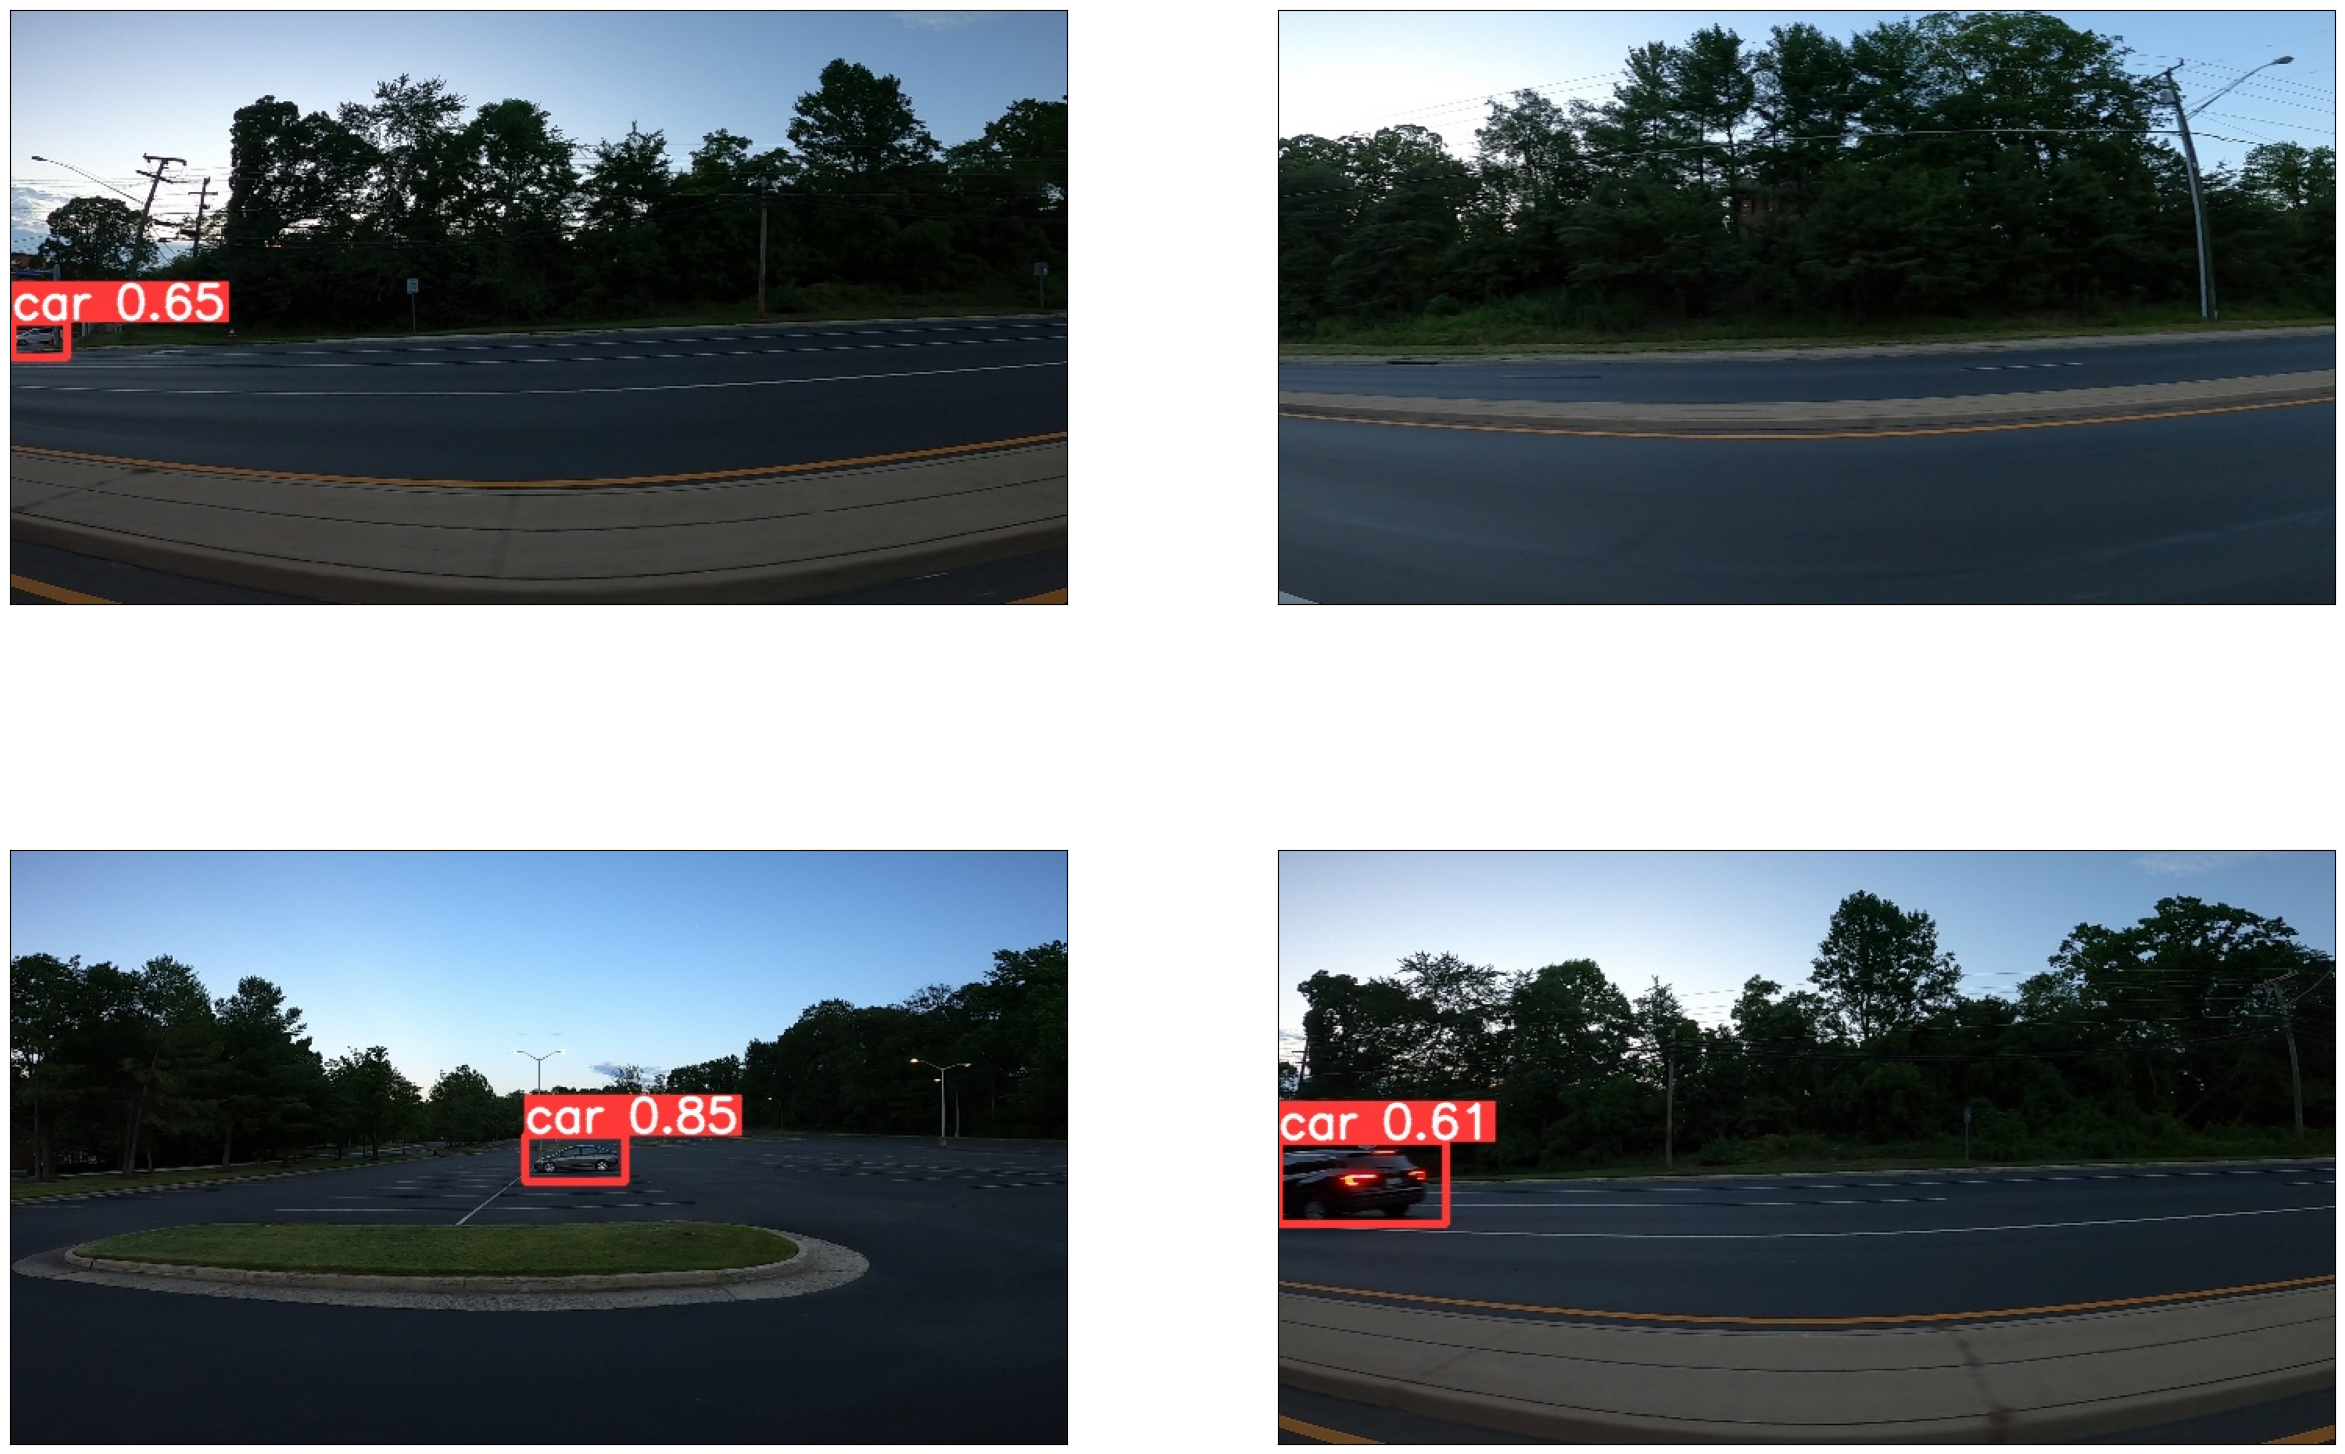

In [157]:
plt.figure(figsize=(30, 20))
for i in range(4):
    random = np.random.randint(0, len(file_paths) - 1)
    plt.subplot(2, 2, i + 1)
    img_path = file_paths[random]
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

## Экспорт модели в tflite, onnx

In [ ]:
!python yolov5/export.py --weights yolov5m.pt --include onnx tflite
clear_output()

## Предскажем сегментацию

In [ ]:
num_predicts = 0

In [138]:
num_predicts +=1
!python  yolov5/segment/predict.py  --source {test_dir} --data dataset.yaml 
clear_output()

 14%|█▎        | 2.01M/14.9M [00:00<00:02, 5.99MB/s]
 19%|█▉        | 2.86M/14.9M [00:00<00:02, 5.26MB/s]
 30%|███       | 4.51M/14.9M [00:00<00:01, 8.24MB/s]
 37%|███▋      | 5.56M/14.9M [00:00<00:01, 8.96MB/s]
 46%|████▌     | 6.80M/14.9M [00:00<00:00, 9.80MB/s]


In [139]:
number_pred = "" if num_predicts == 1 else str(num_predicts)
pred_dir = 'yolov5/runs/predict-seg/exp' + number_pred
file_paths = []
flist = os.listdir(pred_dir)
for file in flist:
    fpath = os.path.join(pred_dir, file)
    file_paths.append(fpath)
clear_output()

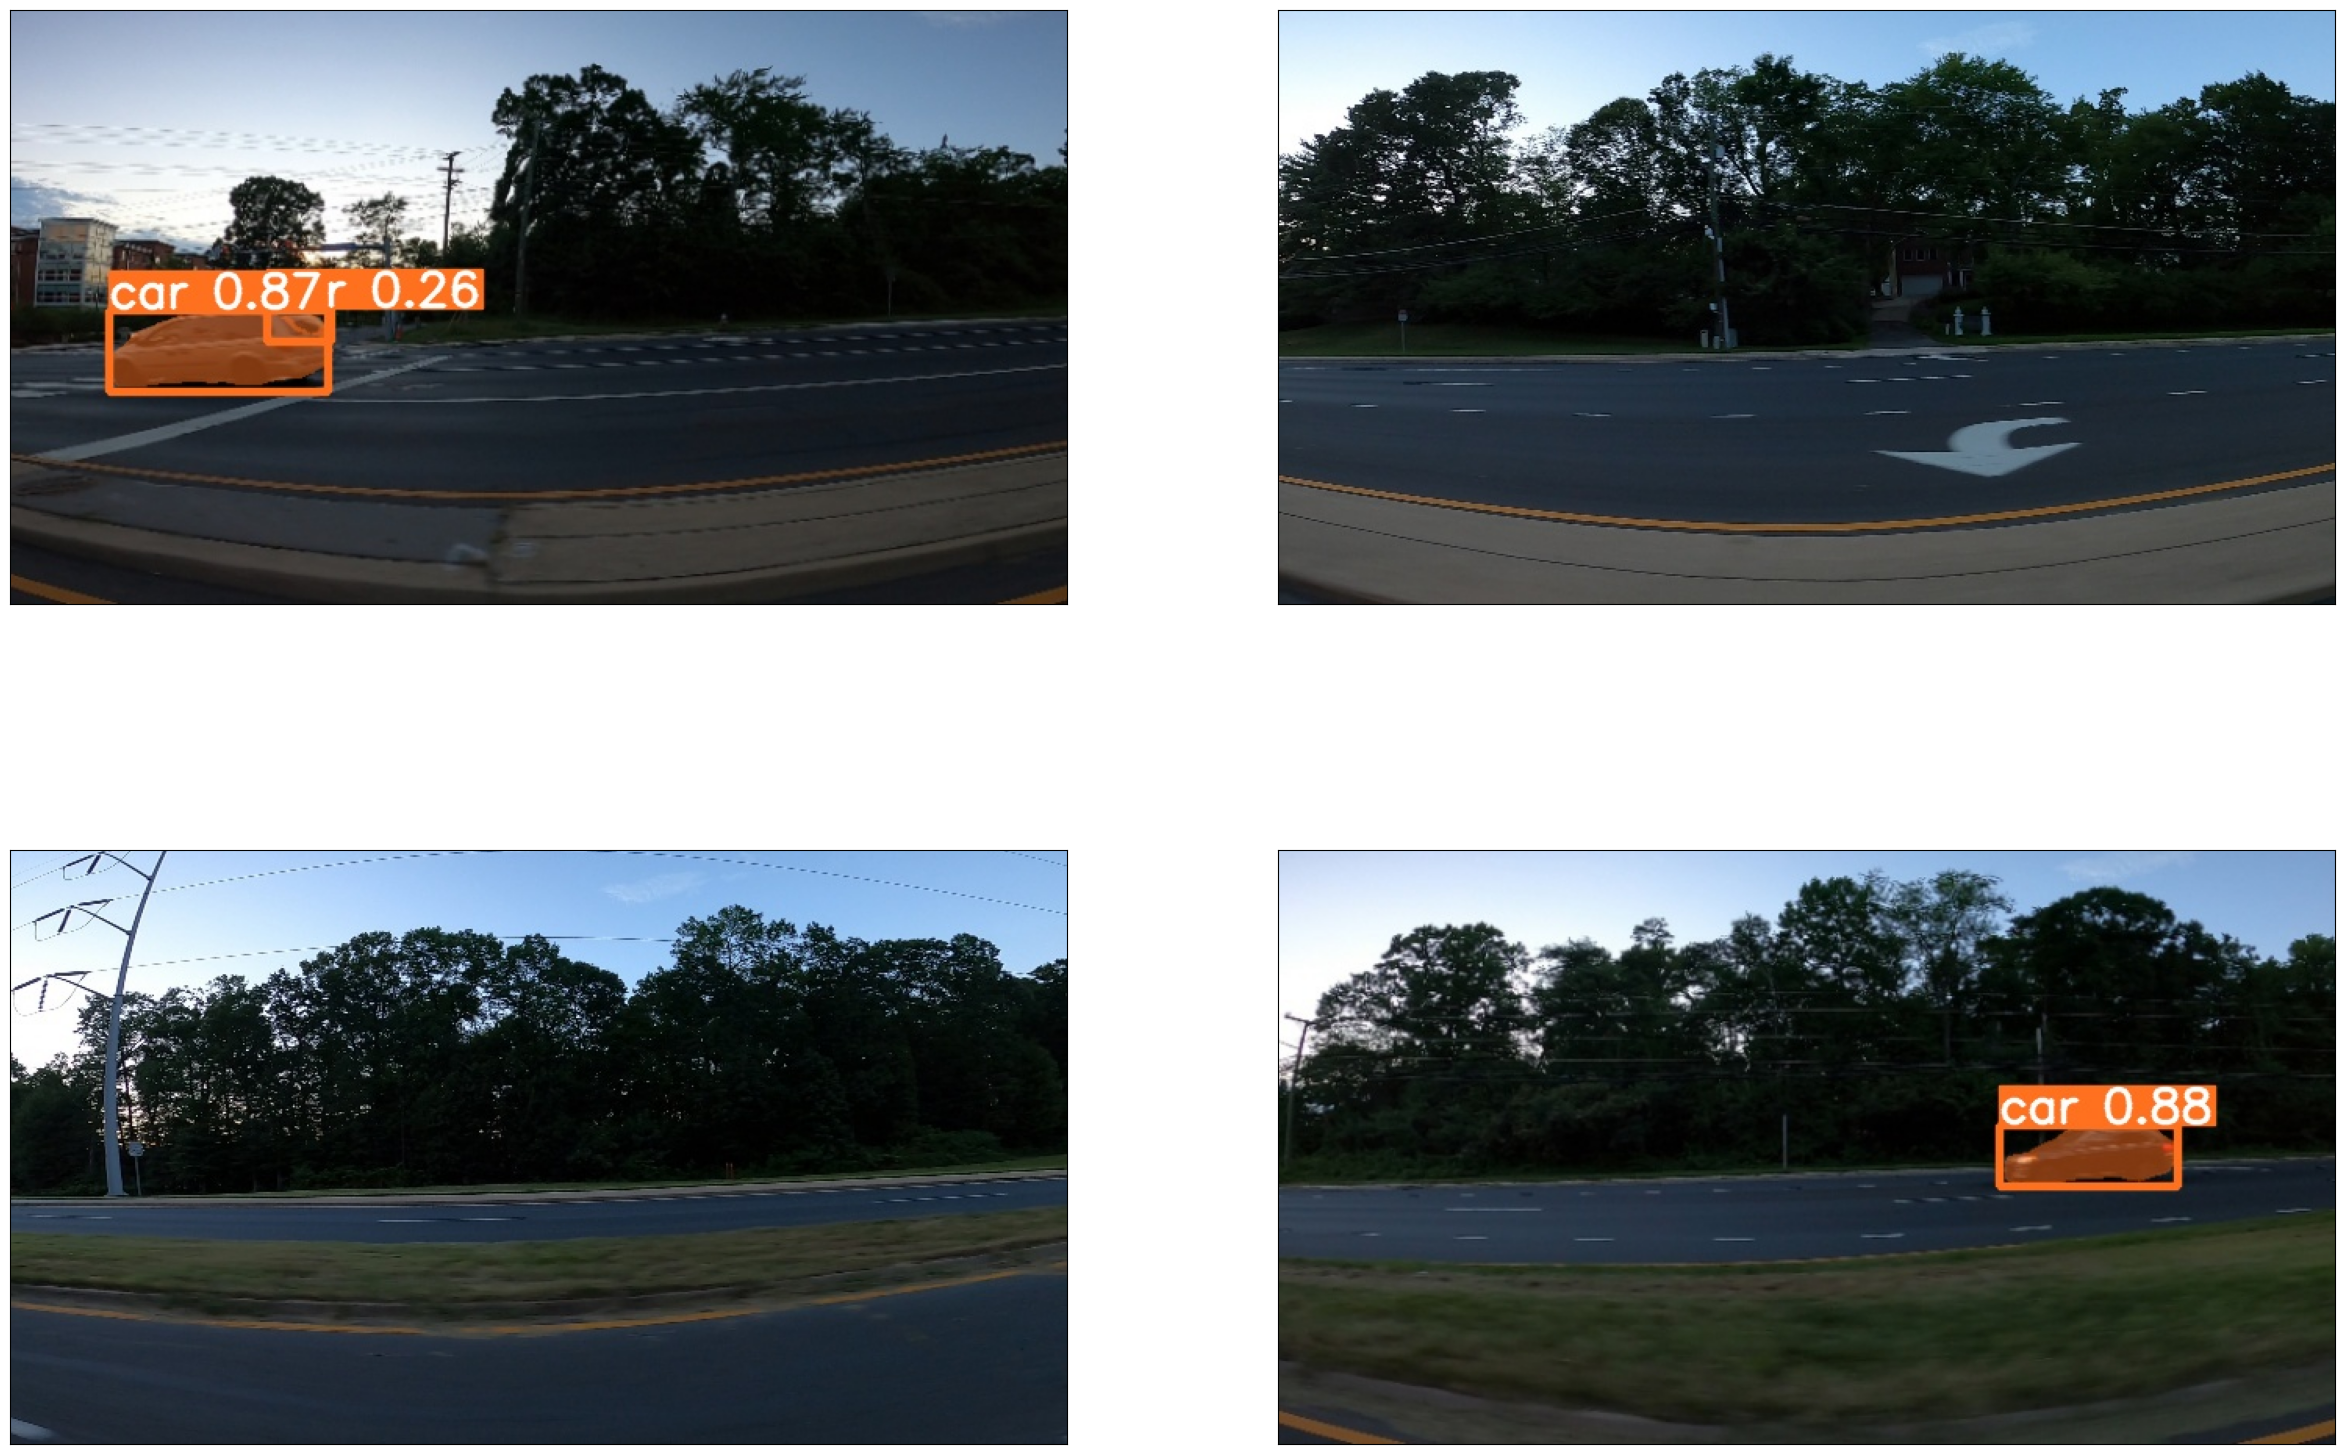

In [140]:
plt.figure(figsize=(30, 20))
for i in range(4):
    random = np.random.randint(0, len(file_paths) - 1)
    plt.subplot(2, 2, i + 1)
    img_path = file_paths[random]
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    
plt.show()